In [7]:
import torch
import torchvision
from torchvision.transforms import v2
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

import os
import math
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import wandb
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
from torch.utils.data import Dataset

class KidneyDataset(Dataset):
    def __init__(self, csv_dir, root_dir, transform=None):
        self.csv = pd.read_csv(csv_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        row = self.csv.iloc[idx]
        img_path = self.root_dir / row['diag'] / (row['image_id'] + '.jpg')
        img = Image.open(img_path).convert('RGB')
        label = row['target']

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [10]:
# Define color codes for terminal
class Colors:
    RESET = '\033[0m'
    GREEN = '\033[92m'
    RED = '\033[91m'
    YELLOW = '\033[93m'
    CYAN = '\033[96m'

def display_progress_bar(batch_idx, num_batches, loss, accuracy):
    """
    Function to display a colored progress bar.
    Args:
        batch_idx: Current batch index
        num_batches: Total number of batches
        loss: Current loss value
        accuracy: Current accuracy value
    """
    progress = (batch_idx + 1) / num_batches
    bar_length = 40  # Length of the progress bar (number of '==' chars)
    filled_length = int(bar_length * progress)
    bar = f"{Colors.GREEN}{'=' * filled_length}{Colors.RED}{'-' * (bar_length - filled_length)}{Colors.RESET}"

    print(f'\r[{bar}] {batch_idx + 1}/{num_batches} | {Colors.YELLOW}Loss:{Colors.RESET} {loss:.3f} | {Colors.YELLOW}Accuracy:{Colors.RESET} {accuracy:.2f}%', end='', flush=True)

In [11]:
import matplotlib.pyplot as plt

def plot_result(history, title="Training Progress"):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train', color='tomato')
    plt.plot(epochs, history['val_loss'], label='Validation', color='steelblue')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train', color='mediumseagreen')
    plt.plot(epochs, history['val_acc'], label='Validation', color='black')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [12]:
def train_one_epoch(model, trainloader, input_dim, show_progress):
  train_loss, avg_loss = 0.0, 0.0
  correct, total = 0, 0 # for accuracy calculation
  num_train_batches = len(trainloader)

  model.train()

  for batch_idx, (inputs, targets) in enumerate(trainloader):
      # flattening input dim for KAN
      # [batch_size, 3, H, W] -> [batch_size, input_dim * input_dim *]
      if input_dim is not None:
          inputs = inputs.view(-1, input_dim * input_dim * 3).to(device)
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, preds = outputs.max(1)
      total += targets.size(0)
      correct += preds.eq(targets).sum().item()

      if show_progress:
          acc = 100. * correct / total
          avg_loss = train_loss / (batch_idx + 1)
          display_progress_bar(batch_idx, num_train_batches, avg_loss, acc)

  train_epoch_loss = train_loss / num_train_batches
  train_epoch_acc = 100. * correct / total

  return train_epoch_loss, train_epoch_acc

In [13]:
def val_one_epoch(model, valloader, input_dim, show_progress):
  val_loss, avg_loss = 0.0, 0.0
  correct, total = 0, 0
  all_preds, all_targets = [], []
  num_val_batches = len(valloader)

  model.eval()

  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(valloader):

          if input_dim is not None:
              inputs = inputs.view(-1, input_dim * input_dim * 3).to(device)
          inputs, targets = inputs.to(device), targets.to(device)

          outputs = model(inputs)
          loss = criterion(outputs, targets)

          val_loss += loss.item()
          _, preds = outputs.max(1)
          total += targets.size(0)
          correct += preds.eq(targets).sum().item()

          all_preds.extend(preds.cpu().numpy())
          all_targets.extend(targets.cpu().numpy())

          if show_progress:
            acc = 100. * correct / total
            avg_loss = val_loss / (batch_idx + 1)
            display_progress_bar(batch_idx, num_val_batches, avg_loss, acc)

  val_epoch_loss = val_loss / num_val_batches
  val_epoch_acc = 100. * correct / total

  return all_preds, all_targets, val_epoch_loss, val_epoch_acc

In [14]:
def evaluate_test_set(model, testloader, device, criterion, model_path, input_dim=None):
  test_loss = 0.0
  correct, total = 0, 0
  all_preds, all_targets = [], []

  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()


  with torch.no_grad():
    for inputs, targets in testloader:
          if input_dim is not None:
              inputs = inputs.view(-1, input_dim * input_dim * 3).to(device)
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          test_loss += loss.item()
          _, preds = outputs.max(1)
          total += targets.size(0)
          correct += preds.eq(targets).sum().item()

          all_preds.extend(preds.cpu().numpy())
          all_targets.extend(targets.cpu().numpy())

  avg_test_loss = test_loss / len(testloader)
  test_acc = 100. * correct / total

  print(f"\nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

  return avg_test_loss, test_acc, all_preds, all_targets

In [15]:
def train_model(model, trainloader, valloader, device,
                             optimizer, criterion, epochs=10, model_name="model", input_dim=None,
                             use_wandb=False, project_name=None, show_progress=True):
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []
    best_vloss = 1_000_000.
    epochs_without_improvement = 0
    patience = 20
    best_model_state =  None

    model.to(device)
    start_time = time.time()

    if use_wandb:
        wandb.init(project=project_name)
        wandb.watch(model, log="all")

    for epoch in range(epochs):
        timestamp = datetime.fromtimestamp(start_time).strftime('%Y%m%d_%H%M%S')
        model_path = f"{model_name}_e{epoch}_{timestamp}.pt"

        # ---------- Training ----------
        print(f"\nEpoch {epoch + 1}/{epochs} - Training")
        train_epoch_loss, train_epoch_acc= train_one_epoch(model, trainloader, input_dim, show_progress)
        train_loss_list.append(train_epoch_loss)
        train_acc_list.append(train_epoch_acc)

        # ---------- Evaluation ----------
        print(f"\nEpoch {epoch + 1}/{epochs} - Evaluation")
        all_preds, all_targets, val_epoch_loss, val_epoch_acc = val_one_epoch(model, valloader, input_dim, show_progress)
        val_loss_list.append(val_epoch_loss)
        val_acc_list.append(val_epoch_acc)

        # Track best performance, and save the model's state
        if val_epoch_loss < best_vloss:
          best_vloss = val_epoch_loss
          best_model_state = model.state_dict()
          torch.save(best_model_state, model_path)
          epochs_without_improvement = 0
        else:
          epochs_without_improvement += 1

        # If no imporvement for "patience" number of epochs, stop early
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping at epoch {epoch+1} with best validation loss: {best_vloss:.4f}")
            model.load_state_dict(best_model_state, model_path)  # Restore the best model state
            break

        print(f"\nTrain Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.2f}%")
        print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Acc: {val_epoch_acc:.2f}%")

        if use_wandb:
            wandb.log({
                "Train Loss": train_epoch_loss,
                "Train Accuracy": train_epoch_acc,
                "Validation Loss": val_epoch_loss,
                "Validation Accuracy": val_epoch_acc,
                "Epoch": epoch + 1
            })

    elapsed = time.time() - start_time
    print(f"\nTraining complete in {elapsed // 60:.0f}m {elapsed % 60:.0f}s.")

    if use_wandb:
        wandb.finish()

    return {
        "model": model,
        "train_loss": train_loss_list,
        "train_acc": train_acc_list,
        "val_loss": val_loss_list,
        "val_acc": val_acc_list,
        "predictions": all_preds,
        "targets": all_targets
    }


In [16]:
def evaluate_test_set(model, testloader, device, criterion, model_path, input_dim=None):
  test_loss = 0.0
  correct, total = 0, 0
  all_preds, all_targets = [], []

  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()


  with torch.no_grad():
    for inputs, targets in testloader:
          if input_dim is not None:
              inputs = inputs.view(-1, input_dim * input_dim * 3).to(device)
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          test_loss += loss.item()
          _, preds = outputs.max(1)
          total += targets.size(0)
          correct += preds.eq(targets).sum().item()

          all_preds.extend(preds.cpu().numpy())
          all_targets.extend(targets.cpu().numpy())

  avg_test_loss = test_loss / len(testloader)
  test_acc = 100. * correct / total

  print(f"\nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

  return avg_test_loss, test_acc, all_preds, all_targets

In [17]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [31]:
classes = 4
input_dim = 128
lr = 0.001
epochs = 70
batch_size = 64

torch.manual_seed(42)

train_transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

val_transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

csv_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv'
root_dir = Path('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')

dataset = KidneyDataset(csv_dir, root_dir, transform=None)

dataset_size = len(dataset)

train_size = int(0.7 * dataset_size)   # 70% for training
val_size   = int(0.15 * dataset_size)  # 15% for validation
test_size  = dataset_size - train_size - val_size  # remaining 15%

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
from torchvision.models import vit_b_16
from torchvision.models import VisionTransformer

model = VisionTransformer(
    image_size=128,
    patch_size=16,
    hidden_dim=768,
    mlp_dim=3072,
    num_layers=12,
    num_heads=12,
    num_classes=classes
)

total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {total_params}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr,weight_decay=0.01)

In [ ]:
result = train_model(model, train_loader, val_loader, device, optimizer, criterion, epochs, model_name="ViT")


Epoch 1/70 - Training
[========================================] 137/137 | Loss: 1.230 | Accuracy: 51.55%
Epoch 1/70 - Evaluation
[========================================] 30/30 | Loss: 1.080 | Accuracy: 61.31%
Train Loss: 1.2304, Train Acc: 51.55%
Validation Loss: 1.0800, Validation Acc: 61.31%

Epoch 2/70 - Training
[========================================] 137/137 | Loss: 0.932 | Accuracy: 64.80%
Epoch 2/70 - Evaluation
[========================================] 30/30 | Loss: 1.107 | Accuracy: 44.59%
Train Loss: 0.9321, Train Acc: 64.80%
Validation Loss: 1.1066, Validation Acc: 44.59%

Epoch 3/70 - Training
[========================================] 137/137 | Loss: 0.958 | Accuracy: 62.84%
Epoch 3/70 - Evaluation
[========================================] 30/30 | Loss: 0.987 | Accuracy: 62.27%
Train Loss: 0.9576, Train Acc: 62.84%
Validation Loss: 0.9866, Validation Acc: 62.27%

Epoch 4/70 - Training
[========================================] 137/137 | Loss: 1.033 | Accuracy: 61.

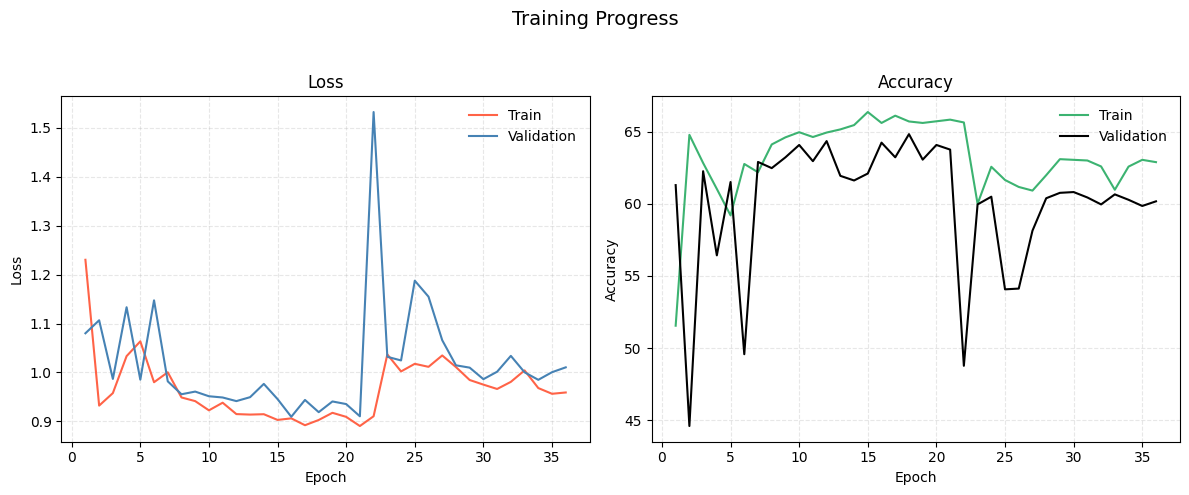

In [34]:
plot_result(result)